In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_large.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_large_no_x.npz")
m, l, c, y = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

s = np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_large.npy')

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))


s.shape = (7168, 19)
m.shape = (7168, 19)
l.shape = (7168, 19)
c.shape = (7168, 19, 55)


In [3]:
#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type_1 = 'leslie_count_pooled'
cell_type_2 = 'leslie_count_testis'

c_1 = c[:, :, cell_type_dict[cell_type_1]]
y_1 = y[:, :, cell_type_dict[cell_type_1]]

c_2 = c[:, :, cell_type_dict[cell_type_2]]
y_2 = y[:, :, cell_type_dict[cell_type_2]]


In [4]:

l_prox_cumulative = np.log(np.cumsum(l[:, ::-1], axis=1) * m[:, ::-1] + 1.)[:, ::-1]
l_cumulative = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.log(l * m + 1.)


In [5]:

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

#prox_index = np.zeros(m.shape[0], dtype=np.int)
#dist_index = np.argmin(m, axis=1) -1


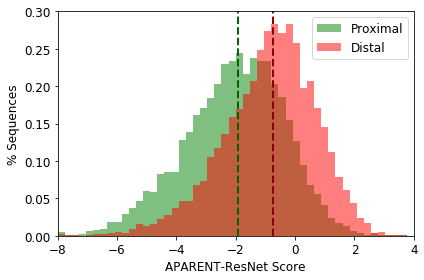

In [6]:
#Proximal-most vs Distal-most PAS scores

s_prox = []
s_dist = []
for i in range(s.shape[0]) :
    s_prox.append(s[i, prox_index[i]])
    s_dist.append(s[i, dist_index[i]])

s_prox = np.array(s_prox)
s_dist = np.array(s_dist)

s_min = -8.
s_max = 4.

prox_hist, bin_edges = np.histogram(s_prox, bins=50, range=(s_min, s_max), density=True)
dist_hist, _ = np.histogram(s_dist, bins=50, range=(s_min, s_max), density=True)

median_prox = np.median(s_prox)
median_dist = np.median(s_dist)

bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width / 2.

f = plt.figure(figsize=(6, 4))

plt.bar(bin_centers, prox_hist, width=bin_width, color='green', alpha=0.5, label='Proximal')
plt.bar(bin_centers, dist_hist, width=bin_width, color='red', alpha=0.5, label='Distal')

plt.axvline(x=median_prox, linestyle='--', linewidth=2, color='darkgreen')
plt.axvline(x=median_dist, linestyle='--', linewidth=2, color='darkred')

plt.xlim(s_min, s_max)
plt.ylim(0, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT-ResNet Score", fontsize=12)
plt.ylabel("% Sequences", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.show()



In [7]:

l_dist = []
l_cumulative_dist = []
for i in range(s.shape[0]) :
    l_dist.append(l[i, dist_index[i]])
    l_cumulative_dist.append(l_cumulative[i, dist_index[i]])

l_dist = np.array(l_dist)
l_cumulative_dist = np.array(l_cumulative_dist)


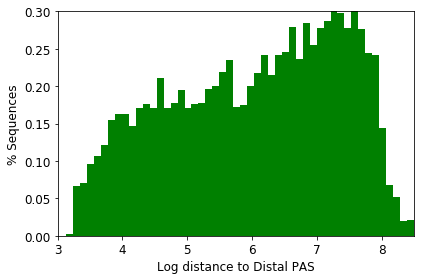

0.16055484533204847
1.6053295329150009e-41


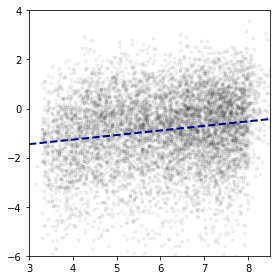

T-test Statistic = -10.526818452019487
T-test P-value = 2.9777386013340597e-25


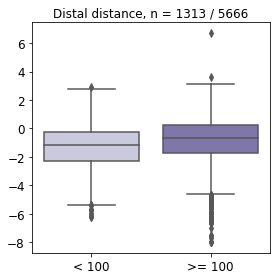

'\n0.1631864976876821\n1.5383399876052946e-41\n'

In [8]:

min_l = 3.
max_l = 8.5#14.

keep_index = (l_dist >= min_l) & (l_dist < max_l)

f = plt.figure(figsize=(6, 4))

plt.hist(l_dist[keep_index], bins=50, color='green', density=True)

plt.xlim(min_l, max_l)
plt.ylim(0, 0.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Log distance to Distal PAS", fontsize=12)
plt.ylabel("% Sequences", fontsize=12)

plt.tight_layout()

plt.show()


r_val, p_val = spearmanr(l_dist[keep_index], s_dist[keep_index])

print(r_val)
print(p_val)

lr = LinearRegression().fit(l_dist[keep_index][:, None], s_dist[keep_index][:, None])

min_s_fit, max_s_fit = lr.predict(np.array([min_l, max_l])[:, None])

f = plt.figure(figsize=(4, 4))

plt.scatter(l_dist[keep_index], s_dist[keep_index], color='black', s=8, alpha=0.05)

plt.plot([min_l, max_l], [min_s_fit, max_s_fit], linewidth=2, color='darkblue', linestyle='--')

plt.xlim(min_l, max_l)
plt.ylim(-6., 4.)

plt.tight_layout()

plt.show()


distance_cutoff = 100

arr_1 = np.array(s_dist[keep_index][l_dist[keep_index] < np.log(distance_cutoff)])
arr_2 = np.array(s_dist[keep_index][l_dist[keep_index] >= np.log(distance_cutoff)])

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[arr_1, arr_2], palette='Purples')

plt.xticks([0, 1], ['< ' + str(distance_cutoff), '>= ' + str(distance_cutoff)], fontsize=12)
plt.yticks(fontsize=12)

n_1 = arr_1.shape[0]
n_2 = arr_2.shape[0]

stat, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(stat))
print("T-test P-value = " + str(p))

plt.title("Distal distance, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.show()

'''
0.1631864976876821
1.5383399876052946e-41
'''


In [8]:
#Proximal-most vs Distal-most PAS scores

s_dists = []
s_dist_means = []
s_dist_medians = []
s_dist_stds = []
for k in range(0, 19) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 :
            s_d.append(s[i, dist_index[i] - k])
    
    s_dists.append(np.array(s_d))
    
    s_dist_means.append(np.mean(s_dists[-1]))
    s_dist_medians.append(np.median(s_dists[-1]))
    s_dist_stds.append(np.std(s_dists[-1]))

s_dist_means = np.array(s_dist_means)
s_dist_medians = np.array(s_dist_medians)
s_dist_stds = np.array(s_dist_stds)


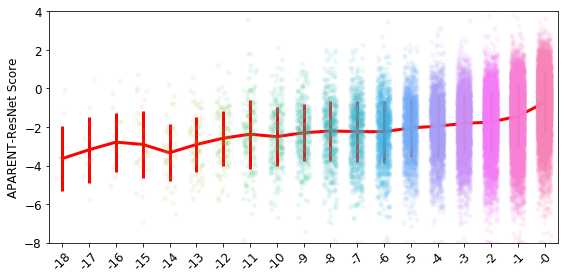

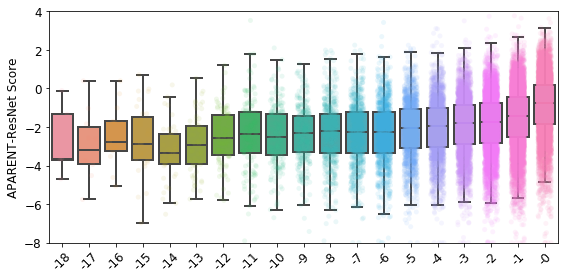

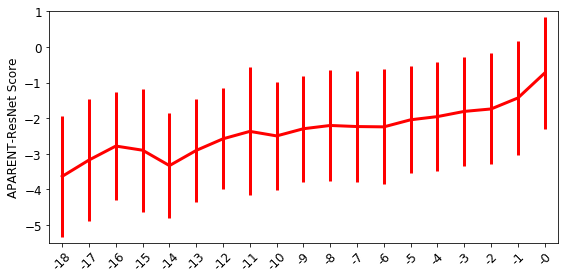

In [9]:

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists[::-1], alpha=0.1, jitter=0.25)

plt.errorbar(np.arange(19), s_dist_medians[::-1], yerr=s_dist_stds[::-1], linewidth=3, color='red', linestyle='-')

plt.xlim(-0.5, 18.5)
plt.ylim(-8., 4.)

plt.xticks(
    np.arange(19),
    ["-" + str(18-j) if j != 29 else "Distal\nPAS" for j in range(19)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(8, 4))

sns.stripplot(data=s_dists[::-1], alpha=0.1, jitter=0.25)
sns.boxplot(data=s_dists[::-1], linewidth=2, fliersize=0.)

plt.xlim(-0.5, 18.5)
plt.ylim(-8., 4.)

plt.xticks(
    np.arange(19),
    ["-" + str(18-j) if j != 29 else "Distal\nPAS" for j in range(19)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(8, 4))

plt.errorbar(np.arange(19), s_dist_medians[::-1], yerr=s_dist_stds[::-1], linewidth=3, color='red', linestyle='-')

plt.xlim(-0.5, 18.5)
plt.ylim(-5.5, 1.)

plt.xticks(
    np.arange(19),
    ["-" + str(18-j) if j != 29 else "Distal\nPAS" for j in range(19)], fontsize=12, rotation=45
)

plt.yticks(fontsize=12)

plt.ylabel("APARENT-ResNet Score", fontsize=12)

plt.tight_layout()

plt.show()


Training on tissue = 'apadb_count_pooled'
Optimization terminated successfully.
         Current function value: 0.400105
         Iterations: 301
         Function evaluations: 17818
         Gradient evaluations: 302
- Spearman r = 0.707
- n = 7168


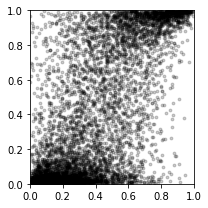

Training on tissue = 'leslie_count_pooled'
Optimization terminated successfully.
         Current function value: 0.555125
         Iterations: 301
         Function evaluations: 17818
         Gradient evaluations: 302
- Spearman r = 0.657
- n = 7168


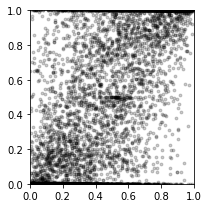

Training on tissue = 'derti_count_pooled'
Optimization terminated successfully.
         Current function value: 0.582648
         Iterations: 434
         Function evaluations: 25724
         Gradient evaluations: 436
- Spearman r = 0.552
- n = 7168


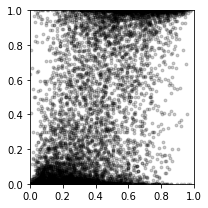

In [11]:
#Fit regression / classification models on native measures

def logistic_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score_exp = np.exp(w_pas[None, :] * s + w_len[None, :] * l + w_bias[None, :]) * m
    
    return score_exp / np.sum(score_exp, axis=-1)[:, None]

def logistic_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0:19]
    w_len = w_bundle[19:19*2]
    w_bias = w_bundle[19*2:19*3]
    
    y_pred = logistic_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = np.sum(y_true_clip * np.log(y_true_clip / y_pred_clip), axis=-1)
    
    return np.mean(kl)

chosen_tissue_types = ['apadb_count_pooled', 'leslie_count_pooled', 'derti_count_pooled']

model_spearman_rs = np.zeros(len(chosen_tissue_types))

y_preds = []

for tissue_ix in range(len(chosen_tissue_types)) :
    
    print("Training on tissue = '" + chosen_tissue_types[tissue_ix] + "'")
    
    y_tissue = y[..., cell_type_dict[chosen_tissue_types[tissue_ix]]]
    
    w0 = np.zeros(19 * 3)

    res = minimize(logistic_model_mse, w0, args=(s, m, l, y_tissue), method='BFGS', options={'disp': True})

    w_pas = res.x[0:19]
    w_len = res.x[19:19*2]
    w_bias = res.x[19*2:19*3]
    
    y_pred_tissue = logistic_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    y_preds.append(y_pred_tissue)
    
    spearman_r_val, _ = spearmanr(y_pred_tissue[np.arange(y_tissue.shape[0]), dist_index], y_tissue[np.arange(y_tissue.shape[0]), dist_index])
    model_spearman_rs[tissue_ix] = spearman_r_val
    
    print("- Spearman r = " + str(round(spearman_r_val, 3)))
    print("- n = " + str(y_tissue.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_pred_tissue[np.arange(y_tissue.shape[0]), dist_index], y_tissue[np.arange(y_tissue.shape[0]), dist_index], color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


APADB vs Leslie
- Spearman r = 0.847
- n = 7168


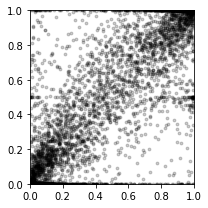

APADB vs Derti
- Spearman r = 0.718
- n = 7168


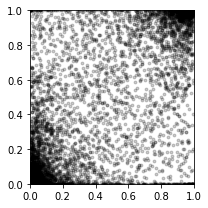

Leslie vs Derti
- Spearman r = 0.637
- n = 7168


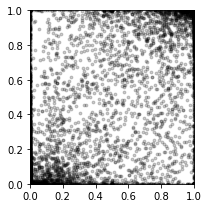

In [12]:
#Correlate measured distal isoform propotions between sources

y_dist_apadb = y[np.arange(y.shape[0]), dist_index, cell_type_dict['apadb_count_pooled']]
y_dist_leslie = y[np.arange(y.shape[0]), dist_index, cell_type_dict['leslie_count_pooled']]
y_dist_derti = y[np.arange(y.shape[0]), dist_index, cell_type_dict['derti_count_pooled']]

y_names = ['APADB', 'Leslie', 'Derti']
y_dists = [y_dist_apadb, y_dist_leslie, y_dist_derti]

for i in range(len(y_names)) :
    for j in range(i + 1, len(y_names)) :
        
        print(y_names[i] + " vs " + y_names[j])
        
        spearman_r_val, _ = spearmanr(y_dists[i], y_dists[j])
        
        print("- Spearman r = " + str(round(spearman_r_val, 3)))
        print("- n = " + str(y_dists[i].shape[0]))

        f = plt.figure(figsize=(3, 3))

        plt.scatter(y_dists[i], y_dists[j], color='black', s=8, alpha=0.2)

        plt.xlim(0., 1.)
        plt.ylim(0., 1.)

        plt.tight_layout()
        plt.show()


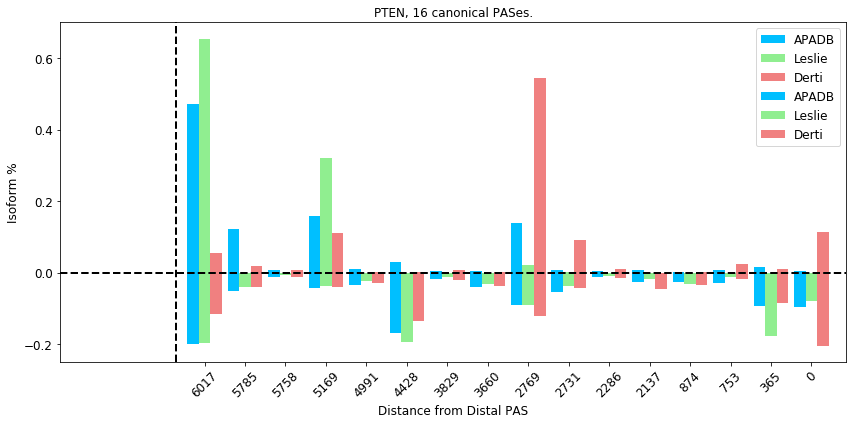

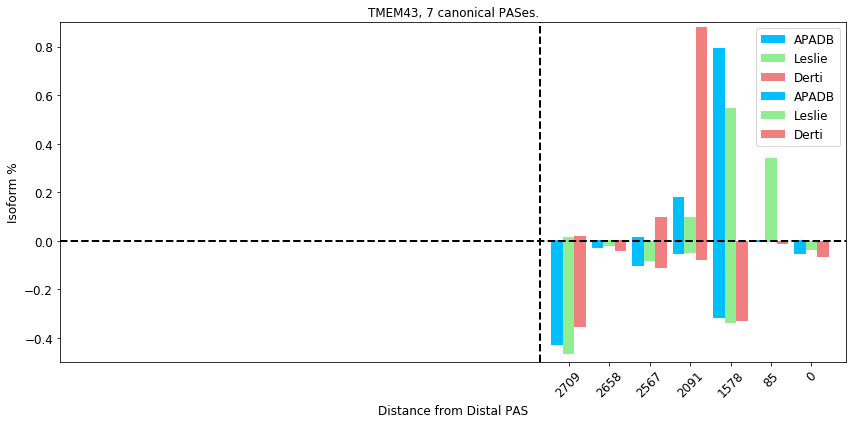

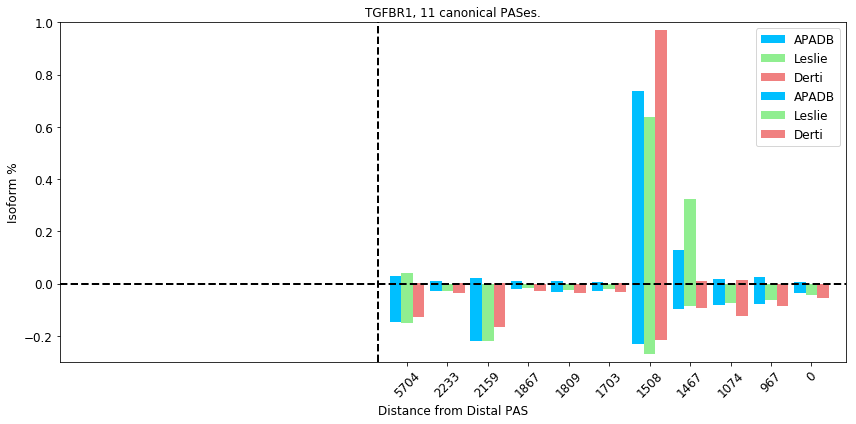

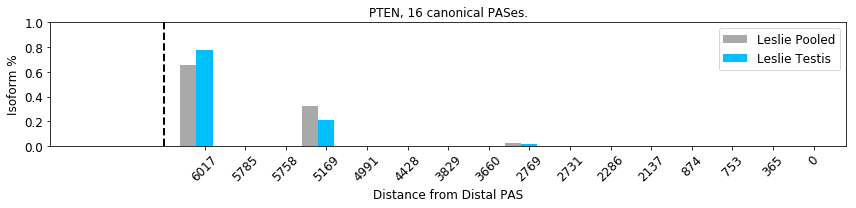

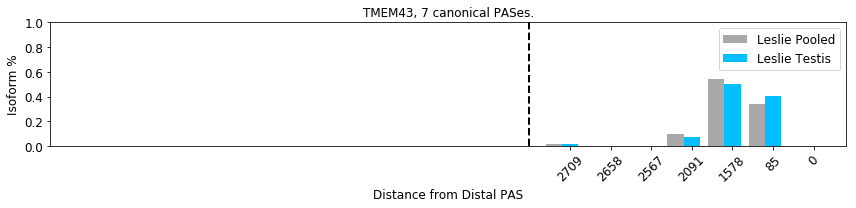

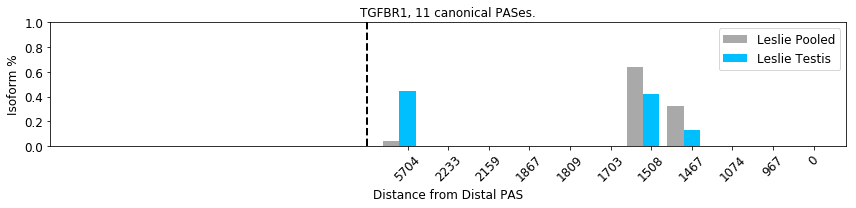

In [14]:
#Examine 3 individual many-PAS genes

genes = ['PTEN', 'TMEM43', 'TGFBR1']

df_ind = [972, 4851, 6871]

#Plot examples, with regressed isoform proportions

genes = ['PTEN', 'TMEM43', 'TGFBR1']

df_ind = [972, 4851, 6871]

for gene_i, gene_ix in enumerate(df_ind) :
    
    y_apadb = y[gene_ix, :, cell_type_dict['apadb_count_pooled']]
    y_leslie = y[gene_ix, :, cell_type_dict['leslie_count_pooled']]
    y_derti = y[gene_ix, :, cell_type_dict['derti_count_pooled']]
    
    y_apadb_pred = y_preds[0][gene_ix, :]
    y_leslie_pred = y_preds[1][gene_ix, :]
    y_derti_pred = y_preds[2][gene_ix, :]
    
    n_pas = int(np.sum(m[gene_ix, :]))
    
    shift_bias = 19 - n_pas
    
    l_prox_exp = [int(s) for s in np.round(np.concatenate([np.zeros(shift_bias), np.exp(l_prox_cumulative[gene_ix, 1:-shift_bias]), np.zeros(1)], axis=0), 0)]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.bar(np.arange(m.shape[1]) * 3.5 + 0 + shift_bias * 3.5, y_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
    plt.bar(np.arange(m.shape[1]) * 3.5 + 1 + shift_bias * 3.5, y_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
    plt.bar(np.arange(m.shape[1]) * 3.5 + 2 + shift_bias * 3.5, y_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')
    #----
    plt.bar(np.arange(m.shape[1]) * 3.5 + 0 + shift_bias * 3.5, -y_apadb_pred, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
    plt.bar(np.arange(m.shape[1]) * 3.5 + 1 + shift_bias * 3.5, -y_leslie_pred, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
    plt.bar(np.arange(m.shape[1]) * 3.5 + 2 + shift_bias * 3.5, -y_derti_pred, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

    plt.axvline(x=shift_bias * 3.5 - 1.5, linewidth=2, linestyle='--', color='black')
    plt.axhline(y=0., linewidth=2, linestyle='--', color='black')
    
    plt.xlim(-1.0, 3.5 * 19 + 0.5)
    plt.ylim(-0.25 if gene_i in [0] else (-0.3 if gene_i in [2] else -0.5), 0.7 if gene_i in [0] else (0.9 if gene_i in [1] else  1.))

    plt.xticks(np.arange(n_pas) * 3.5 + 1 + shift_bias * 3.5, l_prox_exp[shift_bias:], rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel('Distance from Distal PAS', fontsize=12)
    plt.ylabel('Isoform %', fontsize=12)

    plt.legend(fontsize=12)
    
    plt.title(genes[gene_i] + ", " + str(n_pas) + " canonical PASes.", fontsize=12)

    plt.tight_layout()
    
    plt.savefig("native_multi_pas_example_with_pred_iso_" + genes[gene_i] + ".eps")

    plt.show()

#Re-plot examples, Leslie source only, Pooled vs. Testis

for gene_i, gene_ix in enumerate(df_ind) :
    
    y_leslie_pooled = y[gene_ix, :, cell_type_dict['leslie_count_pooled']]
    y_leslie_testis = y[gene_ix, :, cell_type_dict['leslie_count_testis']]
    
    n_pas = int(np.sum(m[gene_ix, :]))
    
    shift_bias = 19 - n_pas
    
    l_prox_exp = [int(s) for s in np.round(np.concatenate([np.zeros(shift_bias), np.exp(l_prox_cumulative[gene_ix, 1:-shift_bias]), np.zeros(1)], axis=0), 0)]
    
    f = plt.figure(figsize=(12, 3))
    
    plt.bar(np.arange(m.shape[1]) * 2.5 + 0 + shift_bias * 2.5, y_leslie_pooled, width=1., edgecolor='black', color='darkgrey', linewidth=0, label='Leslie Pooled')
    plt.bar(np.arange(m.shape[1]) * 2.5 + 1 + shift_bias * 2.5, y_leslie_testis, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='Leslie Testis')
    
    plt.axvline(x=shift_bias * 2.5 - 1.5, linewidth=2, linestyle='--', color='black')
    
    plt.xlim(-1.0, 2.5 * 19 + 0.5)
    plt.ylim(0., 1.)

    plt.xticks(np.arange(n_pas) * 2.5 + 1 + shift_bias * 2.5, l_prox_exp[shift_bias:], rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel('Distance from Distal PAS', fontsize=12)
    plt.ylabel('Isoform %', fontsize=12)

    plt.legend(fontsize=12)
    
    plt.title(genes[gene_i] + ", " + str(n_pas) + " canonical PASes.", fontsize=12)

    plt.tight_layout()
    
    plt.savefig("native_multi_pas_example_testis_vs_pooled_" + genes[gene_i] + ".eps")

    plt.show()


In [10]:

y_1_prox = []
y_2_prox = []
for i in range(s.shape[0]) :
    y_1_prox.append(y_1[i, prox_index[i]])
    y_2_prox.append(y_2[i, prox_index[i]])

y_1_prox = np.array(y_1_prox)
y_2_prox = np.array(y_2_prox)

logodds_1_prox = np.log(np.clip(y_1_prox, 1e-6, 1. - 1e-6) / (1. - np.clip(y_1_prox, 1e-6, 1. - 1e-6)))
logodds_2_prox = np.log(np.clip(y_2_prox, 1e-6, 1. - 1e-6) / (1. - np.clip(y_2_prox, 1e-6, 1. - 1e-6)))

y_1_dist = []
y_2_dist = []
for i in range(s.shape[0]) :
    y_1_dist.append(y_1[i, dist_index[i]])
    y_2_dist.append(y_2[i, dist_index[i]])

y_1_dist = np.array(y_1_dist)
y_2_dist = np.array(y_2_dist)

logodds_1_dist = np.log(np.clip(y_1_dist, 1e-6, 1. - 1e-6) / (1. - np.clip(y_1_dist, 1e-6, 1. - 1e-6)))
logodds_2_dist = np.log(np.clip(y_2_dist, 1e-6, 1. - 1e-6) / (1. - np.clip(y_2_dist, 1e-6, 1. - 1e-6)))


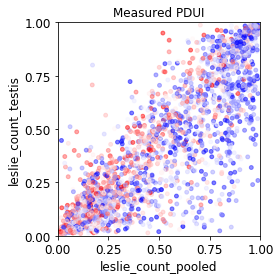

In [11]:

min_count = 20.

total_count_1 = np.sum(c_1, axis=1)
total_count_2 = np.sum(c_2, axis=1)

keep_index = (total_count_1 >= min_count) & (total_count_2 >= min_count)
keep_index = keep_index & ((y_1_dist > 0.01) & (y_1_dist < .99))
keep_index = keep_index & ((y_2_dist > 0.01) & (y_2_dist < .99))
#keep_index = keep_index & ((y_1_prox > 0.001) & (y_1_prox < .999))
#keep_index = keep_index & ((y_2_prox > 0.001) & (y_2_prox < .999))


s_prox_std = (s_prox - np.mean(s_prox)) / np.std(s_prox)
s_dist_std = (s_dist - np.mean(s_dist)) / np.std(s_dist)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_1_dist[keep_index], y_2_dist[keep_index], cmap='bwr', c=(s_prox_std - s_dist_std)[keep_index], vmin=-2., vmax=2., s=15, alpha=0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PDUI", fontsize=12)

plt.tight_layout()

plt.show()


0.20510927294944242
6.544042706049284e-23
2262


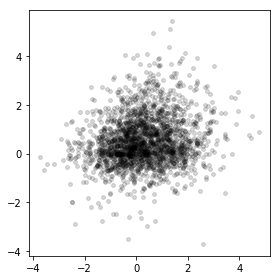

In [12]:

r_val, p_val = spearmanr((s_dist_std - s_prox_std + l_dist)[keep_index], (logodds_1_dist - logodds_2_dist)[keep_index])

print(r_val)
print(p_val)
print(s_dist_std[keep_index].shape[0])

f = plt.figure(figsize=(4, 4))

plt.scatter((s_dist_std - s_prox_std)[keep_index], (logodds_1_dist - logodds_2_dist)[keep_index], color='black', s=15, alpha=0.15)

plt.tight_layout()

plt.show()


T-test Statistic = -6.7526723479325605
T-test P-value = 2.8722416229662177e-11


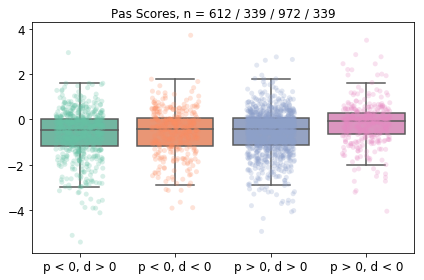

In [13]:

y_diff_dist = y_2_dist - y_1_dist
logodds_ratio_dist = logodds_2_dist - logodds_1_dist#y_2_dist - y_1_dist#

low_prox_low_dist_index = keep_index & ((s_prox_std < 0.) & (s_dist_std < 0.))
low_prox_high_dist_index = keep_index & ((s_prox_std < 0.) & (s_dist_std >= 0.))
high_prox_low_dist_index = keep_index & ((s_prox_std >= 0.) & (s_dist_std < 0.))
high_prox_high_dist_index = keep_index & ((s_prox_std >= 0.) & (s_dist_std >= 0.))

low_prox_low_dist = logodds_ratio_dist[low_prox_low_dist_index]
low_prox_high_dist = logodds_ratio_dist[low_prox_high_dist_index]
high_prox_low_dist = logodds_ratio_dist[high_prox_low_dist_index]
high_prox_high_dist = logodds_ratio_dist[high_prox_high_dist_index]

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[low_prox_high_dist, low_prox_low_dist, high_prox_high_dist, high_prox_low_dist], palette='Set2', alpha=0.25, jitter=0.25)
sns.boxplot(data=[low_prox_high_dist, low_prox_low_dist, high_prox_high_dist, high_prox_low_dist], palette='Set2', fliersize=0.0)

plt.xticks([0, 1, 2, 3], ['p < 0, d > 0', 'p < 0, d < 0', 'p > 0, d > 0', 'p > 0, d < 0'], fontsize=12)
plt.yticks(fontsize=12)

n_1 = low_prox_high_dist.shape[0]
n_2 = low_prox_low_dist.shape[0]
n_3 = high_prox_high_dist.shape[0]
n_4 = high_prox_low_dist.shape[0]

arr_1 = np.concatenate([low_prox_high_dist], axis=0)
arr_2 = np.concatenate([high_prox_low_dist], axis=0)

stat, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(stat))
print("T-test P-value = " + str(p))

plt.title("Pas Scores, n = " + str(n_1) + " / " + str(n_2) + " / " + str(n_3) + " / " + str(n_4), fontsize=12)

plt.tight_layout()

plt.show()


In [14]:
#Proximal-most vs Distal-most PAS scores

s_prox_flat = []
s_dist_flat = []

logodds_1_prox_flat = []
logodds_2_prox_flat = []

y_1_prox_flat = []
y_2_prox_flat = []

total_count_1_flat = []
total_count_2_flat = []

l_prox_flat = []

for i in range(s.shape[0]) :
    for k in range(0, 19) :
        if k < dist_index[i] :
            if (y_1[i, k] > 0.001 and y_1[i, k] < 0.999) and (y_2[i, k] > 0.001 and y_2[i, k] < 0.999) :
                s_prox_flat.append(s[i, k])
                s_dist_flat.append(s[i, dist_index[i]])
                
                logodds_1_prox_flat.append(np.log(y_1[i, k] / (1. - y_1[i, k])))
                logodds_2_prox_flat.append(np.log(y_2[i, k] / (1. - y_2[i, k])))
                
                y_1_prox_flat.append(y_1[i, k])
                y_2_prox_flat.append(y_2[i, k])
                
                total_count_1_flat.append(total_count_1[i])
                total_count_2_flat.append(total_count_2[i])
                
                l_prox_flat.append(l_prox_cumulative[i, k+1])

s_prox_flat = np.array(s_prox_flat)
s_dist_flat = np.array(s_dist_flat)

s_prox_flat_std = (s_prox_flat - np.mean(s_prox_flat)) / np.std(s_prox_flat)
s_dist_flat_std = (s_dist_flat - np.mean(s_dist_flat)) / np.std(s_dist_flat)

logodds_1_prox_flat = np.array(logodds_1_prox_flat)
logodds_2_prox_flat = np.array(logodds_2_prox_flat)

y_1_prox_flat = np.array(y_1_prox_flat)
y_2_prox_flat = np.array(y_2_prox_flat)

total_count_1_flat = np.array(total_count_1_flat)
total_count_2_flat = np.array(total_count_2_flat)

l_prox_flat = np.array(l_prox_flat)

min_count = 50.

keep_index = (total_count_1_flat >= min_count) & (total_count_2_flat >= min_count)


-0.2435035796500619
8.100459874349618e-75
5482


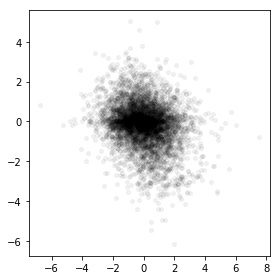

In [15]:

r_val, p_val = spearmanr((s_dist_flat_std - s_prox_flat_std + l_prox_flat)[keep_index], (logodds_1_prox_flat - logodds_2_prox_flat)[keep_index])

print(r_val)
print(p_val)
print(s_dist_flat_std[keep_index].shape[0])

f = plt.figure(figsize=(4, 4))

plt.scatter((s_dist_flat_std - s_prox_flat_std)[keep_index], (logodds_1_prox_flat - logodds_2_prox_flat)[keep_index], color='black', s=15, alpha=0.05)

plt.tight_layout()

plt.show()


T-test Statistic = 14.672653157585122
T-test P-value = 1.5600480078205328e-46


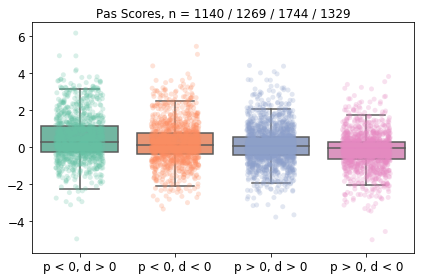

In [16]:

logodds_ratio_prox = logodds_2_prox_flat - logodds_1_prox_flat

low_prox_low_dist_index = keep_index & ((s_prox_flat_std < 0.) & (s_dist_flat_std < 0.))
low_prox_high_dist_index = keep_index & ((s_prox_flat_std < 0.) & (s_dist_flat_std >= 0.))
high_prox_low_dist_index = keep_index & ((s_prox_flat_std >= 0.) & (s_dist_flat_std < 0.))
high_prox_high_dist_index = keep_index & ((s_prox_flat_std >= 0.) & (s_dist_flat_std >= 0.))

low_prox_low_dist = logodds_ratio_prox[low_prox_low_dist_index]
low_prox_high_dist = logodds_ratio_prox[low_prox_high_dist_index]
high_prox_low_dist = logodds_ratio_prox[high_prox_low_dist_index]
high_prox_high_dist = logodds_ratio_prox[high_prox_high_dist_index]

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[low_prox_high_dist, low_prox_low_dist, high_prox_high_dist, high_prox_low_dist], palette='Set2', alpha=0.25, jitter=0.25)
sns.boxplot(data=[low_prox_high_dist, low_prox_low_dist, high_prox_high_dist, high_prox_low_dist], palette='Set2', fliersize=0.0)

plt.xticks([0, 1, 2, 3], ['p < 0, d > 0', 'p < 0, d < 0', 'p > 0, d > 0', 'p > 0, d < 0'], fontsize=12)
plt.yticks(fontsize=12)

n_1 = low_prox_high_dist.shape[0]
n_2 = low_prox_low_dist.shape[0]
n_3 = high_prox_high_dist.shape[0]
n_4 = high_prox_low_dist.shape[0]

arr_1 = np.concatenate([low_prox_high_dist], axis=0)
arr_2 = np.concatenate([high_prox_low_dist], axis=0)

stat, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(stat))
print("T-test P-value = " + str(p))

plt.title("Pas Scores, n = " + str(n_1) + " / " + str(n_2) + " / " + str(n_3) + " / " + str(n_4), fontsize=12)

plt.tight_layout()

plt.show()


T-test Statistic = 15.080280834510186
T-test P-value = 2.493135600545911e-50
Average Fold Change = 1.551


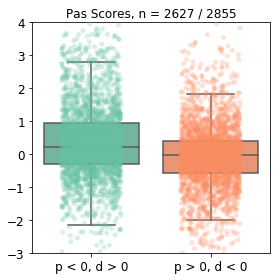

In [25]:

logodds_ratio_prox = logodds_2_prox_flat - logodds_1_prox_flat

low_prox_high_dist_index = keep_index & (s_prox_flat_std - s_dist_flat_std < -0.0)
high_prox_low_dist_index = keep_index & (s_prox_flat_std - s_dist_flat_std >= 0.0)

low_prox_high_dist = logodds_ratio_prox[low_prox_high_dist_index]
high_prox_low_dist = logodds_ratio_prox[high_prox_low_dist_index]

f = plt.figure(figsize=(4, 4))

sns.stripplot(data=[low_prox_high_dist, high_prox_low_dist], palette='Set2', alpha=0.25, jitter=0.25)
sns.boxplot(data=[low_prox_high_dist, high_prox_low_dist], palette='Set2', fliersize=0.0)

plt.xticks([0, 1], ['p < 0, d > 0', 'p > 0, d < 0'], fontsize=12)
plt.yticks(fontsize=12)

n_1 = low_prox_high_dist.shape[0]
n_2 = high_prox_low_dist.shape[0]

arr_1 = np.concatenate([low_prox_high_dist], axis=0)
arr_2 = np.concatenate([high_prox_low_dist], axis=0)

stat, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(stat))
print("T-test P-value = " + str(p))

print("Average Fold Change = " + str(round(np.exp(np.mean(arr_1) - np.mean(arr_2)), 3)))

plt.title("Pas Scores, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.ylim(-3., 4.)

plt.tight_layout()

plt.savefig("apadb_leslie_testis_global_shortening_boxplot.png", transparent=True, dpi=300)
plt.savefig("apadb_leslie_testis_global_shortening_boxplot.eps")

plt.show()


In [28]:
#Proximal-most vs Distal-most PAS scores

ys_1_dists = []
ys_1_dist_means = []
ys_1_dist_medians = []
ys_1_dist_stds = []
for k in range(0, 19) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 and (y_1[i, dist_index[i] - k] > 0. and y_1[i, dist_index[i] - k] < 1.) :
            s_d.append(np.log(y_1[i, dist_index[i] - k] / (1. - y_1[i, dist_index[i] - k])))
    
    ys_1_dists.append(np.array(s_d))
    
    ys_1_dist_means.append(np.mean(ys_1_dists[-1]))
    ys_1_dist_medians.append(np.median(ys_1_dists[-1]))
    ys_1_dist_stds.append(np.std(ys_1_dists[-1]))

ys_1_dist_means = np.array(ys_1_dist_means)
ys_1_dist_medians = np.array(ys_1_dist_medians)
ys_1_dist_stds = np.array(ys_1_dist_stds)


In [29]:
#Proximal-most vs Distal-most PAS scores

ys_2_dists = []
ys_2_dist_means = []
ys_2_dist_medians = []
ys_2_dist_stds = []
for k in range(0, 19) :
    
    s_d = []
    for i in range(s.shape[0]) :
        if dist_index[i] - k >= 0 and (y_2[i, dist_index[i] - k] > 0. and y_2[i, dist_index[i] - k] < 1.) :
            s_d.append(np.log(y_2[i, dist_index[i] - k] / (1. - y_2[i, dist_index[i] - k])))
    
    ys_2_dists.append(np.array(s_d))
    
    ys_2_dist_means.append(np.mean(ys_2_dists[-1]))
    ys_2_dist_medians.append(np.median(ys_2_dists[-1]))
    ys_2_dist_stds.append(np.std(ys_2_dists[-1]))

ys_2_dist_means = np.array(ys_2_dist_means)
ys_2_dist_medians = np.array(ys_2_dist_medians)
ys_2_dist_stds = np.array(ys_2_dist_stds)


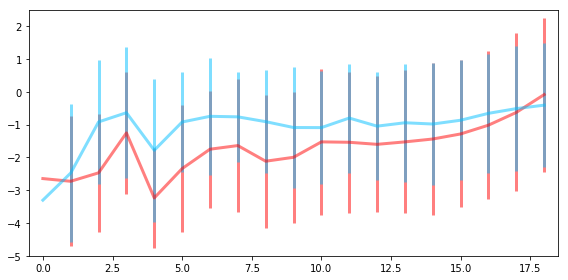

In [33]:

f = plt.figure(figsize=(8, 4))

plt.errorbar(np.arange(19), ys_1_dist_medians[::-1], yerr=ys_1_dist_stds[::-1], alpha=0.5, linewidth=3, color='red', linestyle='-')
plt.errorbar(np.arange(19), ys_2_dist_medians[::-1], yerr=ys_2_dist_stds[::-1], alpha=0.5, linewidth=3, color='deepskyblue', linestyle='-')

plt.xlim(-0.5, 18.5)
plt.ylim(-5., 2.5)

plt.tight_layout()

plt.show()
